In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from tasks.dsm_diffusion import DSMDiffusion
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset, KnownEncoderDiffusionDataset, GRUDiffusionDataset
from data.hmm import CompositionalHMMDataset
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr
from einops import repeat, rearrange
from models.encoder import KnownEncoder
from models.decoder import TransformerDecoder
from tqdm import tqdm
from tasks.metalearn import MetaLearningTask
import torch.nn as nn
import pandas as pd
import seaborn as sns

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mila/l/leo.gagnon/late

In [2]:
task = DSMDiffusion.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/22zbjlpa/last.ckpt", strict=False
)
dataset = task.full_data.base_task.full_data
dataset: KnownEncoderDiffusionDataset

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents', 'model.decoder.no_ctx_emb']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents', 'model.decoder.no_ctx_emb']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents', 'model.decoder.no_ctx_emb']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['full_data.base_task.model.decoder.no_ctx_e

In [3]:
N_SEQS = 50
N_SAMPLES = 20
MAX_LEN = 30

In [4]:
hmms = torch.randperm(len(dataset))[:N_SEQS]

batch = dataset.__getitems__(hmms, length=30)

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [5]:
# Compute the bayesian posterior predictive
oracle_pred = torch.zeros(N_SEQS, MAX_LEN, 50)
for j in range(len(hmms)):
    oracle_pred[j] = torch.Tensor(
        dataset.bayesian_oracle(
            jnp.arange(len(task.full_data.base_task.full_data)),
            t2j(batch['input_ids'])[j]
        )["post_pred"][1:].tolist()
    ).cpu()

In [6]:
explicit_pred = torch.zeros(N_SEQS, MAX_LEN, 50)

for j in tqdm(range(N_SEQS)):
    hmm_post = jnp.exp(
        dataset.bayesian_oracle(
            jnp.arange(len(task.full_data.base_task.full_data)),
            t2j(batch["input_ids"])[j],
        )["log_alpha_post"][1:]
    )
    hmm_post = j2t(hmm_post)

    for i in range(1, MAX_LEN + 1):

        # Sample HMMs from the oracle's posterior
        sampled_hmms = t2j(torch.distributions.categorical.Categorical(
            probs=hmm_post[i-1]
        ).sample((N_SAMPLES,)))

        # Oracle decoder
        post_pred = jax.vmap(dataset.bayesian_oracle, [0, None])(
            sampled_hmms[:, None], t2j(batch["input_ids"])[j]
        )["post_pred"][:, i].mean(0)

        explicit_pred[j, i-1] = j2t(post_pred)

100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


In [7]:
def KLDiv(p,q):
    return torch.sum(p * (p.log() - q.log()), -1)

explicit_kl_b = KLDiv(explicit_pred, oracle_pred)
explicit_kl_f = KLDiv(oracle_pred, explicit_pred)

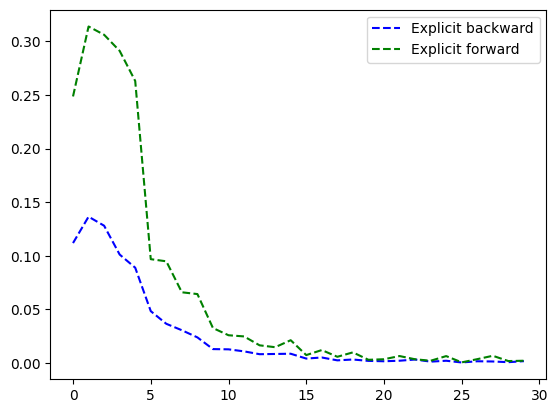

In [8]:
plt.plot(explicit_kl_b.mean(0) , label='Explicit backward', color='blue',linestyle='--')
plt.plot(explicit_kl_f.mean(0) , label='Explicit forward', color='green',linestyle='--')
plt.legend()